In [1]:
!rm -rf diffusionAD

In [2]:
!git clone https://github.com/nguyenduchuyiu/diffusionAD.git

Cloning into 'diffusionAD'...
remote: Enumerating objects: 169, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 169 (delta 67), reused 147 (delta 45), pack-reused 0 (from 0)
Receiving objects: 100% (169/169), 23.44 MiB | 64.35 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [ ]:
# !ls /kaggle/input/k/dangvankhai/diffusionad/diffusionAD/outputs/model/diff-params-ARGS=1/metal_nut/params-last.pt

In [3]:
%cd diffusionAD

/kaggle/working/diffusionAD


In [ ]:
# %%bash
# mkdir -p outputs/model/diff-params-ARGS=1/metal_nut
# cp /kaggle/input/k/dangvankhai/diffusionad/diffusionAD/outputs/model/diff-params-ARGS=1/metal_nut/params-last.pt \
#    outputs/model/diff-params-ARGS=1/metal_nut/params-last.pt


In [4]:
%%writefile args/args1.json

{
  "img_size": [256,256],
  "Batch_Size": 16,
  "EPOCHS": 1800,
  "T": 1000,
  "base_channels": 128,
  "beta_schedule": "linear",
  "loss_type": "l2",
  "diffusion_lr": 1e-4,
  "seg_lr": 1e-5,
  "random_slice": true,
  "weight_decay": 0.0,
  "save_imgs":true,
  "save_vids":false, 
  "dropout":0,
  "attention_resolutions":"32,16,8",
  "num_heads":4,
  "num_head_channels":-1,
  "noise_fn":"gauss",
  "channels":3,
  "data_name":"RealIAD",
  "data_root_path":"/kaggle/input/mvtec-metal-nut/mvtec_reformat",
  "anomaly_source_path":"/kaggle/input/mvtec-metal-nut/mvtec_reformat/dtd",
  "noisier_t_range":600,
  "less_t_range":300,
  "condition_w":1,
  "eval_normal_t":200,
  "eval_noisier_t":400,
  "output_path":"outputs",
  "gradient_accumulation_steps": 1,
  "use_mixed_precision": false,
  "channel_mults": [1, 1, 2, 2, 4, 4],
  "loss_weight": "uniform",
  "loss-type": "l2",
  "resume_training": true,
  "use_gradient_checkpointing": true,
  "use_bfloat16": false
}

Overwriting args/args1.json


In [7]:
%%writefile src/train_seg.py
"""Train segmentation model only with frozen diffusion model"""
import torch
import os
import json
import matplotlib.pyplot as plt
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict

from models import UNetModel, SegmentationSubNetwork, GaussianDiffusionModel, get_beta_schedule
from utils import RealIADTrainDataset

class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=4):
        super().__init__()
        self.alpha, self.gamma = alpha, gamma

    def forward(self, inputs, targets):
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce)
        return torch.mean(self.alpha * (1-pt)**self.gamma * bce)


def train_seg(args, sub_class, device, ckpt_path):
    # Load frozen diffusion model
    checkpoint = torch.load(ckpt_path, map_location=device)
    
    unet = UNetModel(
        args['img_size'][0], args['base_channels'], channel_mults=args['channel_mults'],
        dropout=args["dropout"], n_heads=args["num_heads"], n_head_channels=args["num_head_channels"],
        in_channels=args["channels"]
    ).to(device)
    unet.load_state_dict(checkpoint['unet_model_state_dict'])
    unet.eval()
    for p in unet.parameters():
        p.requires_grad = False

    # Use DataParallel for unet if multiple GPUs are available (mostly defensive, since it's frozen)
    if torch.cuda.device_count() > 1:
        unet = torch.nn.DataParallel(unet)

    # Segmentation model (trainable)
    seg_model = SegmentationSubNetwork(in_channels=6, out_channels=1).to(device)
    seg_model.load_state_dict(checkpoint['seg_model_state_dict'])
    # Use DataParallel for segmentation model if multiple GPUs are available
    if torch.cuda.device_count() > 1:
        seg_model = torch.nn.DataParallel(seg_model)
    # Diffusion sampler
    betas = get_beta_schedule(args['T'], args['beta_schedule'])
    ddpm = GaussianDiffusionModel(
        args['img_size'], betas, loss_weight=args['loss_weight'],
        loss_type=args['loss-type'], noise=args["noise_fn"], img_channels=args["channels"]
    )
    
    # Dataset
    subclass_path = os.path.join(args["data_root_path"], args['data_name'], sub_class)
    dataset = RealIADTrainDataset(subclass_path, sub_class, img_size=args["img_size"], args=args)
    loader = DataLoader(dataset, batch_size=args['Batch_Size'], shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
    
    # Optimizer & Loss
    # Only the parameters of the underlying model are passed to the optimizer
    # (DataParallel exposes a .module attribute)
    optimizer = optim.Adam(
        seg_model.module.parameters() if isinstance(seg_model, torch.nn.DataParallel) else seg_model.parameters(),
        lr=args.get('seg_lr', 1e-4)
    )
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    focal_loss = BinaryFocalLoss().to(device)
    smL1_loss = nn.SmoothL1Loss().to(device)
    
    epochs = args['EPOCHS']
    # lấy trong checkpoint
    losses = {
        'total': checkpoint.get('train_loss_list', []),
        'focal': checkpoint.get('train_focal_loss_list', []),
        'smL1': checkpoint.get('train_smL1_loss_list', [])
    }
    best_loss = float('inf')
    
    for epoch in range(epochs):
        seg_model.train()
        epoch_loss, epoch_focal, epoch_smL1 = 0, 0, 0
        
        tbar = tqdm(loader, desc=f'Epoch {epoch}')
        for sample in tbar:
            aug_image = sample['augmented_image'].to(device)
            anomaly_mask = sample['anomaly_mask'].to(device)
            anomaly_label = sample['has_anomaly'].to(device).squeeze()
            
            with torch.no_grad():
                # If unet is DataParallel, call .module for compatibility with state_dict (already handled above)
                unet_forward = unet
                # Don't need .module here because DataParallel respects __call__
                _, pred_x0, *_ = ddpm.norm_guided_one_step_denoising(unet_forward, aug_image, anomaly_label, args)
            
            pred_mask = seg_model(torch.cat((aug_image, pred_x0), dim=1))
            fl = focal_loss(pred_mask, anomaly_mask)
            sl = smL1_loss(pred_mask, anomaly_mask)
            loss = 5*fl + sl
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_focal += fl.item()
            epoch_smL1 += sl.item()
            tbar.set_postfix(loss=f'{epoch_loss/(tbar.n+1):.4f}')
        
        scheduler.step()
        n_batches = len(loader)
        epoch_loss /= n_batches
        epoch_focal /= n_batches
        epoch_smL1 /= n_batches
        losses['total'].append(epoch_loss)
        losses['focal'].append(epoch_focal)
        losses['smL1'].append(epoch_smL1)
        
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            save_path = f'{args["output_path"]}/model/diff-params-ARGS={args["arg_num"]}/{sub_class}'
            os.makedirs(save_path, exist_ok=True)
            # Save underlying model's state_dict if using DataParallel
            torch.save({
                'seg_model_state_dict': seg_model.module.state_dict() if isinstance(seg_model, torch.nn.DataParallel) else seg_model.state_dict(),
                'epoch': epoch, 'loss': best_loss
            }, f'{save_path}/seg-best.pt')
            print(f'Best model saved at epoch {epoch}, loss={best_loss:.4f}')
        
        if epoch % 100 == 0:
            save_path = f'{args["output_path"]}/model/diff-params-ARGS={args["arg_num"]}/{sub_class}'
            os.makedirs(save_path, exist_ok=True)
            torch.save({
                'seg_model_state_dict': seg_model.module.state_dict() if isinstance(seg_model, torch.nn.DataParallel) else seg_model.state_dict(),
                'epoch': epoch, 'loss': epoch_loss
            }, f'{save_path}/seg-last.pt')
            print(f'Checkpoint saved at epoch {epoch}, loss={epoch_loss:.4f}')
        
        if epoch % 10 == 0:
            plot_losses(losses, sub_class, args)
            
        
    
    plot_losses(losses, sub_class, args, final=True)
    return losses


def plot_losses(losses, sub_class, args, final=False):
    fig, ax = plt.subplots(figsize=(10, 6))
    epochs = range(len(losses['total']))
    ax.plot(epochs, losses['total'], 'b-', label='Total', linewidth=2)
    ax.plot(epochs, losses['focal'], 'r-', label='Focal')
    ax.plot(epochs, losses['smL1'], 'g-', label='SmoothL1')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'{sub_class} - Segmentation Training')
    ax.legend()
    ax.grid(True)
    ax.set_yscale('log')
    plt.tight_layout()
    
    save_dir = f'{args["output_path"]}/learning_curves/ARGS={args["arg_num"]}'
    os.makedirs(save_dir, exist_ok=True)
    suffix = '_final' if final else ''
    plt.savefig(f'{save_dir}/{sub_class}_seg{suffix}.png', dpi=150)
    plt.close()
    
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    with open('./args/args1.json', 'r') as f:
        args = json.load(f)
    ckpt_path = "/kaggle/input/last-metal-nut/pytorch/default/1/params-last.pt"
    args['arg_num'] = '1'
    args = defaultdict(str, args)
    args['EPOCHS'] = 900 # can override
    classes = os.listdir(os.path.join(args["data_root_path"], args['data_name']))
    for sub_class in classes:
        print(f"\n=== Training segmentation for {sub_class} ===")
        train_seg(args, sub_class, device, ckpt_path)


if __name__ == '__main__':
    main()



Overwriting src/train_seg.py


In [8]:
!python -u src/train_seg.py


=== Training segmentation for metal_nut ===
Dataset initialized with 220 training images and 5640 anomaly sources
/kaggle/working/diffusionAD/src/utils.py:485: UserWarning: Argument(s) 'threshold' are not valid for transform Solarize
  A.Solarize(threshold=128, p=1.0),
Epoch 0: 100%|█████████████████████| 13/13 [00:42<00:00,  3.26s/it, loss=0.0849]
Best model saved at epoch 0, loss=0.0849
Checkpoint saved at epoch 0, loss=0.0849
Epoch 2: 100%|█████████████████████| 13/13 [00:47<00:00,  3.62s/it, loss=0.0849]
Best model saved at epoch 2, loss=0.0849
Epoch 3: 100%|█████████████████████| 13/13 [00:45<00:00,  3.51s/it, loss=0.0849]
Best model saved at epoch 3, loss=0.0849
Epoch 5: 100%|█████████████████████| 13/13 [00:45<00:00,  3.51s/it, loss=0.0848]
Best model saved at epoch 5, loss=0.0848
Epoch 6: 100%|█████████████████████| 13/13 [00:45<00:00,  3.53s/it, loss=0.0844]
Best model saved at epoch 6, loss=0.0844
Epoch 7: 100%|█████████████████████| 13/13 [00:45<00:00,  3.53s/it, loss=0.084

In [9]:
!python merge_ckpt.py --params /kaggle/input/last-metal-nut/pytorch/default/1/params-last.pt --seg outputs/model/diff-params-ARGS=1/metal_nut/seg-last.pt --output outputs/model/diff-params-ARGS=1/metal_nut/params-last.pt

Merged checkpoint saved to outputs/model/diff-params-ARGS=1/metal_nut/params-last.pt


In [15]:
%%writefile src/inference.py
import matplotlib.pyplot as plt
import torch
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import auc, roc_curve,average_precision_score
from sklearn.metrics import roc_auc_score
import time
import numpy as np
from scipy.ndimage import gaussian_filter
import cv2
import torch.nn as nn
from models import UNetModel, update_ema_params
from models import SegmentationSubNetwork
import torch.nn as nn
from utils import RealIADTestDataset
from models import GaussianDiffusionModel, get_beta_schedule
from math import exp
import torch.nn.functional as F
torch.cuda.empty_cache()
from tqdm import tqdm
import json
import os
from collections import defaultdict
import pandas as pd
import torchvision.utils
import os
from torch.utils.data import DataLoader
from skimage.measure import label, regionprops
import sys
from utils import BinaryFocalLoss

def preprocess_image(image_path, img_size=(256, 256), channels=3):
    image = cv2.imread(image_path)
    if channels == 1:
        # Convert to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (img_size[1], img_size[0]))
        image = (image / 255.0).astype(np.float32)
        image = torch.from_numpy(image).unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (img_size[1], img_size[0]))
        image = (image / 255.0)
        image = np.transpose(image.astype(np.float32), (2, 0, 1))
        image = torch.from_numpy(image).unsqueeze(0)  # (1, 3, H, W)
    return image

def denormalize_image(tensor_image):
    img = tensor_image.cpu().squeeze(0)
    if img.dim() == 2:  # Grayscale (H, W)
        img_np = img.numpy()
    elif img.shape[0] == 1:  # Grayscale (1, H, W)
        img_np = img.squeeze(0).numpy()
    else:  # RGB (C, H, W)
        img_np = img.permute(1, 2, 0).numpy()
    img_np = (img_np + 1) / 2.0
    img_np = np.nan_to_num(img_np, nan=0.0, posinf=1.0, neginf=0.0)
    img_np = np.clip(img_np * 255, 0, 255).astype(np.uint8)
    # Convert grayscale to RGB for display
    if len(img_np.shape) == 2:
        img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
    return img_np

def gridify_output(img, row_size=-1):
    scale_img = lambda img: ((img + 1) * 127.5).clamp(0, 255).to(torch.uint8)
    return torchvision.utils.make_grid(scale_img(img), nrow=row_size, pad_value=-1).cpu().data.permute(
            0, 2,
            1
            ).contiguous().permute(
            2, 1, 0
            )

def defaultdict_from_json(jsonDict):
    func = lambda: defaultdict(str)
    dd = func()
    dd.update(jsonDict)
    return dd

def load_checkpoint(ckpt_path, device):

    print("checkpoint",ckpt_path)

    from collections import defaultdict
    try:
        torch.serialization.add_safe_globals([defaultdict])
    except Exception:
        pass

    loaded_model = torch.load(ckpt_path, map_location=device, weights_only=False)
    return loaded_model

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def image_transform(image):
     return np.clip(image* 255, 0, 255).astype(np.uint8)
 
def cvt2heatmap(gray):
    heatmap = cv2.applyColorMap(np.uint8(gray), cv2.COLORMAP_JET)
    return heatmap
def show_cam_on_image(img, anomaly_map):
    cam = np.float32(anomaly_map)/255 + np.float32(img)/255
    max_val = np.max(cam)
    if max_val > 0:
        cam = cam / max_val
    return np.uint8(255 * cam) 


def min_max_norm(image):
    a_min, a_max = image.min(), image.max()
    if a_max - a_min == 0:
        return np.zeros_like(image)
    return (image-a_min)/(a_max - a_min)

        
def predict(unet_model, seg_model, ddpm, image_tensor, args, device='cpu', heatmap_threshold=0.6):
    """
    Hàm predict giờ nhận vào image_tensor đã được xử lý và args từ model.
    """
    normal_t = args["eval_normal_t"]
    noiser_t = args["eval_noisier_t"]
    
    image_tensor = image_tensor.to(device)

    normal_t_tensor = torch.tensor([normal_t], device=device).repeat(image_tensor.shape[0])
    noiser_t_tensor = torch.tensor([noiser_t], device=device).repeat(image_tensor.shape[0])

    with torch.no_grad():
        _, pred_x_0_condition, pred_x_0_normal, pred_x_0_noisier, x_normal_t, x_noiser_t, pred_x_t_noisier = ddpm.norm_guided_one_step_denoising_eval(unet_model, image_tensor, normal_t_tensor, noiser_t_tensor, args)
        pred_mask_logits = seg_model(torch.cat((image_tensor, pred_x_0_condition), dim=1))
            
    pred_mask = torch.sigmoid(pred_mask_logits)
    out_mask = pred_mask

    # Tính điểm anomaly
    topk_out_mask = torch.flatten(out_mask[0], start_dim=1)
    topk_out_mask = torch.topk(topk_out_mask, 50, dim=1, largest=True)[0]
    image_score = torch.mean(topk_out_mask)

    # --- Visualisation ---
    # Original image: convert from [0, 1] directly to [0, 255] (not [-1, 1])
    img = image_tensor.cpu().squeeze(0)
    if img.shape[0] == 1:  # Grayscale (1, H, W)
        raw_image_np = img.squeeze(0).numpy()
        raw_image = np.clip(raw_image_np * 255.0, 0, 255).astype(np.uint8)
        raw_image = cv2.cvtColor(raw_image, cv2.COLOR_GRAY2RGB)
    else:  # RGB (C, H, W)
        raw_image_np = img.permute(1, 2, 0).numpy()
        raw_image = np.clip(raw_image_np * 255.0, 0, 255).astype(np.uint8)
    
    # Reconstructed images: use denormalize (model outputs are in [-1, 1])
    recon_condition = denormalize_image(pred_x_0_condition)
    recon_normal_t = denormalize_image(pred_x_0_normal)
    recon_noisier_t = denormalize_image(pred_x_0_noisier)
    
    # Create heatmap with higher contrast
    mask_data = out_mask[0, 0].cpu().numpy().astype(np.float32)
    mask_data[mask_data < heatmap_threshold] = 0
    
    # Apply contrast enhancement using gamma correction
    gamma = 0.1  # Lower gamma = higher contrast for bright areas
    mask_data_enhanced = np.power(np.clip(mask_data, 0, 1), gamma)
    
    ano_map = cv2.GaussianBlur(mask_data_enhanced, (15, 15), 4)
    ano_map = min_max_norm(ano_map)
    ano_map = np.nan_to_num(ano_map, nan=0.0)
    
    # Use HOT colormap for better visibility (red/yellow/white)
    ano_map_heatmap = cv2.applyColorMap(np.uint8(np.clip(ano_map * 255.0, 0, 255)), cv2.COLORMAP_HOT)
    
    # Create overlay
    raw_image_bgr = cv2.cvtColor(raw_image, cv2.COLOR_RGB2BGR)
    ano_map_overlay = show_cam_on_image(raw_image_bgr, ano_map_heatmap)
    ano_map_overlay = cv2.cvtColor(ano_map_overlay, cv2.COLOR_BGR2RGB)
    
    # Hiển thị
    f, axes = plt.subplots(1, 5, figsize=(20, 4))
    f.suptitle(f'Anomaly Score: {image_score:.4f}')

    axes[0].imshow(raw_image)
    axes[0].set_title('Input')
    axes[0].axis('off')

    axes[1].imshow(recon_condition)
    axes[1].set_title('Reconstruction')
    axes[1].axis('off')
    
    axes[2].imshow(recon_noisier_t)
    axes[2].set_title('Recon (Noisier)')
    axes[2].axis('off')
    
    # Create enhanced anomaly mask with high contrast
    mask_raw = out_mask[0][0].cpu().numpy().astype(np.float32)
    mask_raw[mask_raw < heatmap_threshold] = 0
    mask_enhanced = np.power(np.clip(mask_raw, 0, 1), 0.3)
    mask_normalized = min_max_norm(mask_enhanced)
    mask_normalized = np.nan_to_num(mask_normalized, nan=0.0)
    mask_stretched = np.uint8(np.clip(mask_normalized * 255.0, 0, 255))
    anomaly_mask_colored = cv2.applyColorMap(mask_stretched, cv2.COLORMAP_HOT)
    anomaly_mask_colored = cv2.cvtColor(anomaly_mask_colored, cv2.COLOR_BGR2RGB)
    
    axes[3].imshow(anomaly_mask_colored)
    axes[3].set_title('Anomaly Mask')
    axes[3].axis('off')

    axes[4].imshow(ano_map_overlay)
    axes[4].set_title('Heatmap Overlay')
    axes[4].axis('off')

    plt.tight_layout()
    plt.savefig("out.png")
    plt.show()

def predict_image(unet_model, seg_model, ddpm, image_path, args, device='cpu', heatmap_threshold=0.6):
    image_tensor = preprocess_image(image_path, img_size=args['img_size'], channels=args['channels'])
    image_tensor = image_tensor.to(device)
    return predict(unet_model, seg_model, ddpm, image_tensor, args, device, heatmap_threshold)

def predict_batch(unet_model, seg_model, ddpm, image_arrays, args, device='cpu', heatmap_threshold=0.6, batch_size=8, progress_callback=None):
    """
    Predict anomalies for a batch of images with parallel processing
    Args:
        unet_model: UNet model
        seg_model: Segmentation model
        ddpm: DDPM model
        image_arrays: List of numpy image arrays
        args: Model arguments
        device: Device to run on
        heatmap_threshold: Threshold for anomaly detection
        batch_size: Batch size for parallel processing
        progress_callback: Optional callback function(progress, status_text) for progress updates
    Returns:
        List of prediction results with inference_time
    """
    results = []
    total_images = len(image_arrays)
    num_batches = (total_images + batch_size - 1) // batch_size
    
    # Process images in batches
    for batch_idx in range(0, len(image_arrays), batch_size):
        batch_images = image_arrays[batch_idx:batch_idx + batch_size]
        current_batch = batch_idx // batch_size + 1
        
        # Update progress
        if progress_callback is not None:
            progress = batch_idx / total_images
            status_text = f'Processing batch {current_batch}/{num_batches} ({len(batch_images)} images)...'
            progress_callback(progress, status_text)
        
        # Preprocess batch - process all images in parallel
        batch_tensors = []
        for image_array in batch_images:
            if len(image_array.shape) == 3:
                # Check if model expects grayscale
                if args.get('channels', 3) == 1:
                    gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
                    image_tensor = torch.from_numpy(gray.astype(np.float32) / 255.0).unsqueeze(0).unsqueeze(0)
                else:
                    image_tensor = torch.from_numpy(np.transpose(image_array.astype(np.float32) / 255.0, (2, 0, 1))).unsqueeze(0)
            elif len(image_array.shape) == 2:
                image_tensor = torch.from_numpy(image_array.astype(np.float32) / 255.0).unsqueeze(0).unsqueeze(0)
            else:
                raise ValueError("Image must be 2D (H, W) or 3D array (H, W, C)")
            
            # Resize to model input size
            image_tensor = torch.nn.functional.interpolate(image_tensor, size=args['img_size'], mode='bilinear', align_corners=False)
            batch_tensors.append(image_tensor)
        
        # Stack into batch tensor - this enables parallel processing on GPU
        batch_tensor = torch.cat(batch_tensors, dim=0).to(device)
        
        normal_t = args["eval_normal_t"]
        noiser_t = args["eval_noisier_t"]
        
        normal_t_tensor = torch.tensor([normal_t], device=device).repeat(batch_tensor.shape[0])
        noiser_t_tensor = torch.tensor([noiser_t], device=device).repeat(batch_tensor.shape[0])
        
        # Synchronize GPU before timing (for accurate measurement)
        if device.type == 'cuda':
            torch.cuda.synchronize()
        
        # Measure inference time for batch - all images processed in parallel
        inference_start = time.time()
        with torch.no_grad():
            _, pred_x_0_condition, pred_x_0_normal, pred_x_0_noisier, x_normal_t, x_noiser_t, pred_x_t_noisier = ddpm.norm_guided_one_step_denoising_eval(unet_model, batch_tensor, normal_t_tensor, noiser_t_tensor, args)
            pred_mask_logits = seg_model(torch.cat((batch_tensor, pred_x_0_condition), dim=1))
        
        # Synchronize GPU after inference (for accurate timing)
        if device.type == 'cuda':
            torch.cuda.synchronize()
        
        batch_inference_time = time.time() - inference_start
        
        pred_mask = torch.sigmoid(pred_mask_logits)
        out_mask = pred_mask
        
        # Process each image in batch (post-processing)
        for i in range(batch_tensor.shape[0]):
            # Calculate anomaly score
            topk_out_mask = torch.flatten(out_mask[i], start_dim=1)
            topk_out_mask = torch.topk(topk_out_mask, 50, dim=1, largest=True)[0]
            image_score = torch.mean(topk_out_mask).cpu().item()
            
            # Each image in batch is processed in parallel, so effective latency per image
            # is approximately the batch time (since they run simultaneously on GPU)
            # We record the batch time as the inference time for each image
            per_image_time = batch_inference_time
            
            results.append({
                "anomaly_score": float(image_score),
                "is_anomaly": image_score > heatmap_threshold,
                "inference_time": per_image_time
            })
        
        # Update progress after processing batch
        if progress_callback is not None:
            progress = min((batch_idx + len(batch_images)) / total_images, 1.0)
            status_text = f'Completed batch {current_batch}/{num_batches} ({len(results)}/{total_images} images processed)...'
            progress_callback(progress, status_text)
    
    return results

def predict_single_tensor(unet_model, seg_model, ddpm, image_tensor, args, device='cpu', heatmap_threshold=0.6, return_visualizations=True):
    """
    Predict anomaly for a single image tensor
    """
    normal_t = args["eval_normal_t"]
    noiser_t = args["eval_noisier_t"]
    
    image_tensor = image_tensor.to(device)
    normal_t_tensor = torch.tensor([normal_t], device=device).repeat(image_tensor.shape[0])
    noiser_t_tensor = torch.tensor([noiser_t], device=device).repeat(image_tensor.shape[0])

    with torch.no_grad():
        _, pred_x_0_condition, pred_x_0_normal, pred_x_0_noisier, x_normal_t, x_noiser_t, pred_x_t_noisier = ddpm.norm_guided_one_step_denoising_eval(unet_model, image_tensor, normal_t_tensor, noiser_t_tensor, args)
        pred_mask_logits = seg_model(torch.cat((image_tensor, pred_x_0_condition), dim=1))
            
    pred_mask = torch.sigmoid(pred_mask_logits)
    out_mask = pred_mask

    # Calculate anomaly score
    topk_out_mask = torch.flatten(out_mask[0], start_dim=1)
    topk_out_mask = torch.topk(topk_out_mask, 50, dim=1, largest=True)[0]
    image_score = torch.mean(topk_out_mask).cpu().item()

    result = {
        "anomaly_score": float(image_score),
        "is_anomaly": image_score > heatmap_threshold
    }
    
    if return_visualizations:
        # Create visualizations
        # Original image: convert from [0, 1] directly to [0, 255] (not [-1, 1])
        img = image_tensor.cpu().squeeze(0)
        if img.shape[0] == 1:  # Grayscale (1, H, W)
            raw_image_np = img.squeeze(0).numpy()
            raw_image = np.clip(raw_image_np * 255.0, 0, 255).astype(np.uint8)
            raw_image = cv2.cvtColor(raw_image, cv2.COLOR_GRAY2RGB)
        else:  # RGB (C, H, W)
            raw_image_np = img.permute(1, 2, 0).numpy()
            raw_image = np.clip(raw_image_np * 255.0, 0, 255).astype(np.uint8)
        
        # Reconstructed images: use denormalize (model outputs are in [-1, 1])
        recon_condition = denormalize_image(pred_x_0_condition)
        recon_noisier_t = denormalize_image(pred_x_0_noisier)
        
        # Create heatmap with higher contrast
        mask_data = out_mask[0, 0].cpu().numpy().astype(np.float32)
        mask_data[mask_data < heatmap_threshold] = 0
        
        # Apply contrast enhancement using gamma correction
        gamma = 0.1  # Lower gamma = higher contrast for bright areas
        mask_data_enhanced = np.power(np.clip(mask_data, 0, 1), gamma)
        
        ano_map = cv2.GaussianBlur(mask_data_enhanced, (15, 15), 4)
        ano_map = min_max_norm(ano_map)
        ano_map = np.nan_to_num(ano_map, nan=0.0)
        
        # Use HOT colormap for better visibility (red/yellow/white)
        ano_map_heatmap = cv2.applyColorMap(np.uint8(np.clip(ano_map * 255.0, 0, 255)), cv2.COLORMAP_HOT)
        
        # Create overlay
        raw_image_bgr = cv2.cvtColor(raw_image, cv2.COLOR_RGB2BGR)
        ano_map_overlay = show_cam_on_image(raw_image_bgr, ano_map_heatmap)
        ano_map_overlay = cv2.cvtColor(ano_map_overlay, cv2.COLOR_BGR2RGB)
        
        # Create enhanced anomaly mask with high contrast
        mask_raw = out_mask[0][0].cpu().numpy().astype(np.float32)
        mask_raw[mask_raw < heatmap_threshold] = 0
        mask_enhanced = np.power(np.clip(mask_raw, 0, 1), 0.3)
        mask_normalized = min_max_norm(mask_enhanced)
        mask_normalized = np.nan_to_num(mask_normalized, nan=0.0)
        mask_stretched = np.uint8(np.clip(mask_normalized * 255.0, 0, 255))
        anomaly_mask_colored = cv2.applyColorMap(mask_stretched, cv2.COLORMAP_HOT)
        anomaly_mask_colored = cv2.cvtColor(anomaly_mask_colored, cv2.COLOR_BGR2RGB)
        
        result.update({
            "original_image": raw_image,
            "reconstructed_image": recon_condition,
            "recon_noisier": recon_noisier_t,
            "anomaly_mask": anomaly_mask_colored,
            "heatmap_overlay": ano_map_overlay,
            "heatmap": ano_map
        })
    
    return result

def predict_single_image_array(unet_model, seg_model, ddpm, image_array, args, device='cpu', heatmap_threshold=0.6):
    """
    Predict anomaly for a single image array (numpy array)
    Args:
        unet_model: UNet model
        seg_model: Segmentation model
        ddpm: DDPM model
        image_array: numpy array of shape (H, W, C) with values in [0, 255]
        args: Model arguments
        device: Device to run on
        heatmap_threshold: Threshold for anomaly detection
    Returns:
        Dictionary with prediction results and visualizations
    """
    import time
    
    # Preprocess image
    if len(image_array.shape) == 3:
        # Check if model expects grayscale
        if args.get('channels', 3) == 1:
            # Convert RGB to grayscale
            gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
            image_tensor = torch.from_numpy(gray.astype(np.float32) / 255.0).unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)
        else:
            image_tensor = torch.from_numpy(np.transpose(image_array.astype(np.float32) / 255.0, (2, 0, 1))).unsqueeze(0)
    elif len(image_array.shape) == 2:
        # Already grayscale
        image_tensor = torch.from_numpy(image_array.astype(np.float32) / 255.0).unsqueeze(0).unsqueeze(0)
    else:
        raise ValueError("Image must be 2D (H, W) or 3D array (H, W, C)")
    
    # Resize to model input size
    image_tensor = torch.nn.functional.interpolate(image_tensor, size=args['img_size'], mode='bilinear', align_corners=False)
    
    # Measure inference time
    inference_start = time.time()
    result = predict_single_tensor(unet_model, seg_model, ddpm, image_tensor, args, device, heatmap_threshold, return_visualizations=True)
    inference_time = time.time() - inference_start
    
    result['inference_time'] = inference_time
    return result

if __name__ == "__main__":
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # device = torch.device("cpu")
    print(f"Using device: {device}")
    
    ckpt_path = "outputs/model/diff-params-ARGS=1/metal_nut/params-last.pt"
    image_path = "/kaggle/input/mvtec-metal-nut/mvtec_reformat/RealIAD/metal_nut/test/bad/000.png"
    # ckpt_path = "params-best (1).pt"
    # image_path = "datasets/denso_dataset/mat_tru/test/bad/7_2024_9_5_11_25_49_8_P4.png"
    heatmap_threshold = 0.5
    # 1. Load checkpoint và lấy args từ đó
    ckpt_state = load_checkpoint(ckpt_path, device)
    args = ckpt_state['args']
    args = defaultdict_from_json(args)
    print(args)
    
    # 2. Khởi tạo model với args đã load
    unet_model = UNetModel(args['img_size'][0], args['base_channels'], channel_mults=args['channel_mults'], dropout=args[
                "dropout"], n_heads=args["num_heads"], n_head_channels=args["num_head_channels"],
            in_channels=args["channels"]
            ).to(device)

    seg_model = SegmentationSubNetwork(in_channels=args["channels"] * 2, out_channels=1).to(device)

    # 3. Khởi tạo DDPM
    betas = get_beta_schedule(args['T'], args['beta_schedule'])
    
    ddpm =  GaussianDiffusionModel(
            args['img_size'], betas, loss_weight=args['loss_weight'],
            loss_type=args['loss-type'], noise=args["noise_fn"], img_channels=args["channels"]
            )
    
    # 4. Load state dicts vào model
    unet_model.load_state_dict(ckpt_state['unet_model_state_dict'])
    seg_model.load_state_dict(ckpt_state['seg_model_state_dict'])
    unet_model.eval()
    seg_model.eval()


    # 5. Chạy predict
    predict_image(unet_model, seg_model, ddpm, image_path, args, device, heatmap_threshold)

Overwriting src/inference.py


In [16]:
!python3 -u src/inference.py

Using device: cuda
checkpoint outputs/model/diff-params-ARGS=1/metal_nut/params-last.pt
defaultdict(<class 'str'>, {'img_size': [256, 256], 'Batch_Size': 16, 'EPOCHS': 1500, 'T': 1000, 'base_channels': 128, 'beta_schedule': 'linear', 'loss_type': 'l2', 'diffusion_lr': 0.0001, 'seg_lr': 1e-05, 'random_slice': True, 'weight_decay': 0.0, 'save_imgs': True, 'save_vids': False, 'dropout': 0, 'attention_resolutions': '32,16,8', 'num_heads': 4, 'num_head_channels': -1, 'noise_fn': 'gauss', 'channels': 3, 'data_name': 'RealIAD', 'data_root_path': 'mvtec_reformat', 'anomaly_source_path': 'mvtec_reformat/dtd', 'noisier_t_range': 600, 'less_t_range': 300, 'condition_w': 1, 'eval_normal_t': 200, 'eval_noisier_t': 400, 'output_path': 'outputs', 'gradient_accumulation_steps': 1, 'use_mixed_precision': False, 'channel_mults': [1, 1, 2, 2, 4, 4], 'loss_weight': 'uniform', 'loss-type': 'l2', 'resume_training': True, 'use_gradient_checkpointing': True, 'use_bfloat16': False, 'arg_num': '1'})
Figure(2000

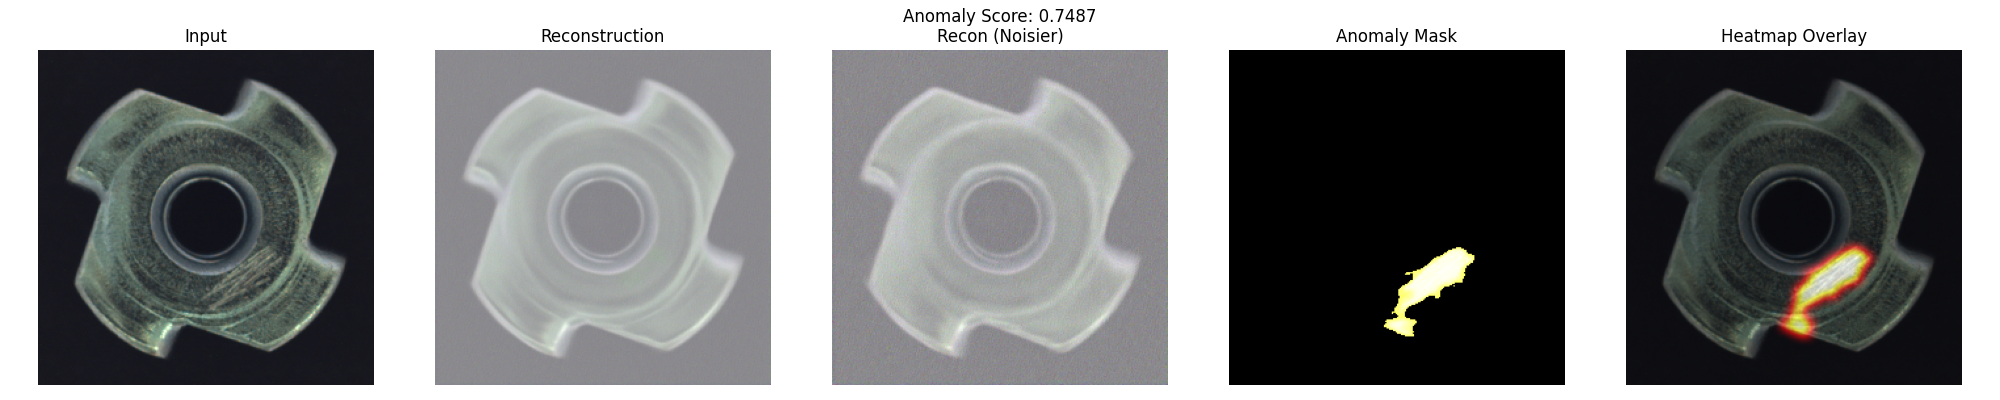

In [17]:
from IPython.display import Image, display
display(Image("out.png"))

In [ ]:
# p.kill()

In [ ]:
# !cp /kaggle/working/diffusionAD/outputs/model/diff-params-ARGS=1/PCB5/params-best.pt /kaggle/working/diffusionAD/outputs/model/diff-params-ARGS=1/PCB5/params-last.pt

In [ ]:

# from eval import testing, load_parameters, defaultdict_from_json

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Check for multiple GPUs
# num_gpus = torch.cuda.device_count()
# print(f"Number of available GPUs: {num_gpus}")
# if num_gpus > 1:
#     print(f"Using {num_gpus} GPUs for evaluation")
# elif num_gpus == 1:
#     print("Using single GPU for evaluation")
# else:
#     print("Using CPU for evaluation")
# file = "args1.json"
# # load the json args
# with open(f'./args/{file}', 'r') as f:
#     args = json.load(f)
# args['arg_num'] = file[4:-5]
# args = defaultdict_from_json(args)
# real_iad_classes = os.listdir(os.path.join(args["data_root_path"], args['data_name']))

# current_classes = real_iad_classes
# checkpoint_types = ['best', 'last']

# for sub_class in current_classes:
#     for checkpoint_type in checkpoint_types:
#         try:
#             args, output = load_parameters(device, sub_class, checkpoint_type)
#         except FileNotFoundError:
#             print(f"Checkpoint {checkpoint_type} not found for class {sub_class}, skipping.")
#             continue

#         print(f"args{args['arg_num']}")
#         print("class", sub_class)
        
#         in_channels = args["channels"]

#         unet_model = UNetModel(args['img_size'][0], args['base_channels'], channel_mults=args['channel_mults'], dropout=args[
#                     "dropout"], n_heads=args["num_heads"], n_head_channels=args["num_head_channels"],
#                 in_channels=in_channels
#                 ).to(device)

#         seg_model = SegmentationSubNetwork(in_channels=6, out_channels=1).to(device)

#         # Load model states
#         unet_model.load_state_dict(output["unet_model_state_dict"])
#         unet_model.to(device)
        
#         seg_model.load_state_dict(output["seg_model_state_dict"])
#         seg_model.to(device)
        
#         # Enable multi-GPU for evaluation if available
#         if num_gpus > 1:
#             print(f"Wrapping models with DataParallel for {num_gpus} GPUs")
#             unet_model = torch.nn.DataParallel(unet_model)
#             seg_model = torch.nn.DataParallel(seg_model)
        
#         unet_model.eval()
#         seg_model.eval()

#         print("EPOCH:", output['n_epoch'])

#         testing_dataset = RealIADTestDataset(
#             args["data_root_path"], sub_class, img_size=args["img_size"]
#         )
#         class_type = args['data_name']
                
#         data_len = len(testing_dataset) 
#         test_loader = DataLoader(testing_dataset, batch_size=1, shuffle=False, num_workers=4)

#         # make arg specific directories
#         for i in [f'{args["output_path"]}/metrics/ARGS={args["arg_num"]}/{sub_class}']:
#             try:
#                 os.makedirs(i)
#             except OSError:
#                 pass

#         testing(test_loader, args, unet_model, seg_model, data_len, sub_class, class_type, checkpoint_type, device)


In [ ]:
# import sys
# !{sys.executable} -m pip install matplotlib